In [1]:
# Dependencies
%pylab inline
import pandas as pd
import numpy as np
import csv
import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


## Data Description
+ H-1B Visa Petitions for 2011 - 2016

+ Source [Kaggle H-1B Visa Petitions 2011-2016](https://www.kaggle.com/nsharan/h-1b-visa)

### Context 
---
The H-1B is an employment-based, non-immigrant visa category for temporary foreign workers in the United States. For a foreign national to apply for H1-B visa, an US employer must offer a job and petition for H-1B visa with the US immigration department. This is the most common visa status applied for and held by international students once they complete college/ higher education (Masters, PhD) and work in a full-time position.

The Office of Foreign Labor Certification (OFLC) generates program data that is useful information about the immigration programs including the H1-B visa.

### Content
#### Number of Instances : 
#### Features:
1. CASE_STATUS: Status associated with the last significant event or decision. Valid values include “Certified,” “Certified-Withdrawn,” Denied,” and “Withdrawn”.  
** NOTE: Certified does not mean the employee was granted an H-1B Visa rather. Certified is a status that allows the application to apply for an H-1B Visa **
2. EMPLOYER_NAME: Name of employer submitting labor condition application
3. SOC_NAME: Standard Occupation Code according to SOC Classification system. 
4. JOB TITLE: Title of the employee position
5. FULL_TIME_POSITION: Y = Full Time Position, N = Part Time Position
6. PREVAILING_WAGE: Prevailing Wage for the job being requested for temporary labor condition. The wage is listed at annual scale in USD. The prevailing wage for a job position is defined as the average wage paid to similarly employed workers in the requested occupation in the area of intended employment. The prevailing wage is based on the employer’s minimum requirements for the position. 
7. YEAR: Year in which the H-1B visa petition was filed
8. WORKSITE: City and State Information of the foreign worker's intended area of employment
9. Lon : Longitude of worksite
10. Lon : latitude of worksite

# Read Data
___

In [2]:
filePath = "./Data/h1b_kaggle.csv"
df = pd.read_csv(filePath, header=0)

### General Data Cleaning
___

In [3]:
df[:3]

,Unnamed: 0,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat
0,1,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,N,36067.0,2016.0,"ANN ARBOR, MICHIGAN",-83.743038,42.280826
1,2,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,Y,242674.0,2016.0,"PLANO, TEXAS",-96.698886,33.019843
2,3,CERTIFIED-WITHDRAWN,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,Y,193066.0,2016.0,"JERSEY CITY, NEW JERSEY",-74.077642,40.728158


+ ** Remove the features that we do not need for any analysis we intend to perform **

In [4]:
# remove the first index column
del df["Unnamed: 0"]

In [5]:
df[:3]

,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,lon,lat
0,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,N,36067.0,2016.0,"ANN ARBOR, MICHIGAN",-83.743038,42.280826
1,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,Y,242674.0,2016.0,"PLANO, TEXAS",-96.698886,33.019843
2,CERTIFIED-WITHDRAWN,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,Y,193066.0,2016.0,"JERSEY CITY, NEW JERSEY",-74.077642,40.728158


In [6]:
# Remove "Lon" and "Lat"
del df["lon"]
del df["lat"]

In [7]:
df[:3]

,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE
0,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,N,36067.0,2016.0,"ANN ARBOR, MICHIGAN"
1,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,Y,242674.0,2016.0,"PLANO, TEXAS"
2,CERTIFIED-WITHDRAWN,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,Y,193066.0,2016.0,"JERSEY CITY, NEW JERSEY"


In [8]:
worksite = df["WORKSITE"]
worksite[:3]

0        ANN ARBOR, MICHIGAN
1               PLANO, TEXAS
2    JERSEY CITY, NEW JERSEY
Name: WORKSITE, dtype: object

In [9]:
df[["CITY", "STATE"]] = df["WORKSITE"].str.split(', ', expand=True)
df[:3]

,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,WORKSITE,CITY,STATE
0,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,N,36067.0,2016.0,"ANN ARBOR, MICHIGAN",ANN ARBOR,MICHIGAN
1,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,Y,242674.0,2016.0,"PLANO, TEXAS",PLANO,TEXAS
2,CERTIFIED-WITHDRAWN,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,Y,193066.0,2016.0,"JERSEY CITY, NEW JERSEY",JERSEY CITY,NEW JERSEY


In [10]:
## Now delete the worksite feature
del df["WORKSITE"]

In [11]:
df[:3]

,CASE_STATUS,EMPLOYER_NAME,SOC_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,CITY,STATE
0,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,BIOCHEMISTS AND BIOPHYSICISTS,POSTDOCTORAL RESEARCH FELLOW,N,36067.0,2016.0,ANN ARBOR,MICHIGAN
1,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF EXECUTIVES,CHIEF OPERATING OFFICER,Y,242674.0,2016.0,PLANO,TEXAS
2,CERTIFIED-WITHDRAWN,"PORTS AMERICA GROUP, INC.",CHIEF EXECUTIVES,CHIEF PROCESS OFFICER,Y,193066.0,2016.0,JERSEY CITY,NEW JERSEY


## Feature-specific Data Cleaning

#### CASE_STATUS
___

In [12]:
case_status_series = df["CASE_STATUS"]

In [13]:
## Analyze the values in Case status
print(case_status_series.value_counts())

CERTIFIED                                             2615623
CERTIFIED-WITHDRAWN                                    202659
DENIED                                                  94346
WITHDRAWN                                               89799
PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED         15
REJECTED                                                    2
INVALIDATED                                                 1
Name: CASE_STATUS, dtype: int64


In [14]:
## We are only intrested in these outcomes 
# certified | certified-withdraw | denied | Withdrawn 
# The others are outliers. Lets remove them 
df.drop(df[df.CASE_STATUS == "REJECTED"].index, axis=0, inplace=True)
df.drop(df[df.CASE_STATUS == "PENDING QUALITY AND COMPLIANCE REVIEW - UNASSIGNED"].index, axis=0, inplace=True)
df.drop(df[df.CASE_STATUS == "INVALIDATED"].index, axis=0, inplace=True)

In [15]:
## Analyze the values in Case status
print(df["CASE_STATUS"].value_counts())

CERTIFIED              2615623
CERTIFIED-WITHDRAWN     202659
DENIED                   94346
WITHDRAWN                89799
Name: CASE_STATUS, dtype: int64


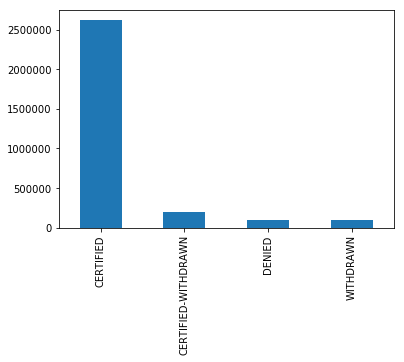

In [16]:
# Check out the distribution of likely outcomes
df["CASE_STATUS"].value_counts().plot.bar()

#### EMPLOYER_NAME
___

In [17]:
# Are there any missing employer names 
print("There %d instances missing employer names" % len(df[pd.isnull(df.EMPLOYER_NAME)]))

There 59 instances missing employer names


+ Since these are not numerical data we cannot imput using a measure of central tendency
+ Since the data seems to be missing completely at random, we should remove it. Cannot figure out what employer name should be from the available data

In [18]:
# Remove Instances without Employer name valued
df = df[pd.notnull(df["EMPLOYER_NAME"])]

#### SOC_NAME
___

+ The SOC_NAME captures the same information as Job title. In the essence of dimension reduction and to only use features that are neccessary. i will remove this feature 

In [19]:
del df["SOC_NAME"]

In [20]:
df[:3]

,CASE_STATUS,EMPLOYER_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,CITY,STATE
0,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,POSTDOCTORAL RESEARCH FELLOW,N,36067.0,2016.0,ANN ARBOR,MICHIGAN
1,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF OPERATING OFFICER,Y,242674.0,2016.0,PLANO,TEXAS
2,CERTIFIED-WITHDRAWN,"PORTS AMERICA GROUP, INC.",CHIEF PROCESS OFFICER,Y,193066.0,2016.0,JERSEY CITY,NEW JERSEY


#### JOB TITLE
___

In [21]:
# Do we have any missing values
print("There %d missing instances of job title" % len(df[pd.isnull(df["JOB_TITLE"])]))

There 21 missing instances of job title


In [22]:
# Remove these missing instances
df = df[pd.notnull(df["JOB_TITLE"])]

In [23]:
# How many distinct Job titles are there 
job_stat = df["JOB_TITLE"].value_counts()
print("There %d distinct jobs in the DataSet" %job_stat[0])

There 249034 distinct jobs in the DataSet


#### FULL_TIME_POSITION
___

In [24]:
# Do we have missing values
print("There %d missing instance of full time" % len(df[pd.isnull(df["FULL_TIME_POSITION"])]))

There 1 missing instance of full time


In [25]:
df[pd.isnull(df["FULL_TIME_POSITION"])]

,CASE_STATUS,EMPLOYER_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,CITY,STATE
131977,DENIED,FOUR SEASONS HEATING AND AIR CONDITIONING,COMPUTER SYSTEMS ANALAYST,NaN,NaN,2016.0,CHICAGO,ILLINOIS


In [26]:
# Remove this instance
df = df[pd.notnull(df["FULL_TIME_POSITION"])]

#### PREVAILING WAGE
___

In [27]:
# Do we have any missing values
print("There %d instances missing prevailing values" % len(df[pd.isnull(df["PREVAILING_WAGE"])]))

There 66 instances missing prevailing values


In [28]:
# Applications have to have a wage provided. 
# Remove instances with wages missing
df = df[pd.notnull(df["PREVAILING_WAGE"])]
df[:2]

,CASE_STATUS,EMPLOYER_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,CITY,STATE
0,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,POSTDOCTORAL RESEARCH FELLOW,N,36067.0,2016.0,ANN ARBOR,MICHIGAN
1,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF OPERATING OFFICER,Y,242674.0,2016.0,PLANO,TEXAS


In [29]:
# We can see that the wage values are in floats. For easier calculations convert these to ints 
df["PREVAILING_WAGE"] = df["PREVAILING_WAGE"].astype(int)
df[:2]

,CASE_STATUS,EMPLOYER_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,CITY,STATE
0,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,POSTDOCTORAL RESEARCH FELLOW,N,36067,2016.0,ANN ARBOR,MICHIGAN
1,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF OPERATING OFFICER,Y,242674,2016.0,PLANO,TEXAS


#### YEAR
___

In [30]:
# Do we have any missing Data
print("There %d instances missing Year values" % len(df[pd.isnull(df["YEAR"])]))

There 0 instances missing Year values


In [31]:
## That is great, Now, need to convert the year as given to ints 
df["YEAR"] = df["YEAR"].astype(int)
df[:2]

,CASE_STATUS,EMPLOYER_NAME,JOB_TITLE,FULL_TIME_POSITION,PREVAILING_WAGE,YEAR,CITY,STATE
0,CERTIFIED-WITHDRAWN,UNIVERSITY OF MICHIGAN,POSTDOCTORAL RESEARCH FELLOW,N,36067,2016,ANN ARBOR,MICHIGAN
1,CERTIFIED-WITHDRAWN,"GOODMAN NETWORKS, INC.",CHIEF OPERATING OFFICER,Y,242674,2016,PLANO,TEXAS


# Data Exploration
---

#### CASE_STATUS
___

#### One average do most appplications get certified, denied or withdrawn ?

In [32]:
df_group = df.groupby("CASE_STATUS")
total = len(df)
print("TOTAL Number of Instances : %d " %total)
print("CERTIFIED : {:04.2f} % ".format(df_group.size()[0]* 100 / total))
print("CERTIFIED-WITHDRAWN: {:04.2f} % ".format(df_group.size()[1]* 100/total))
print("DENIED: {:04.2f} % ".format(df_group.size()[2]* 100/total))
print("WITHDRAWN: {:04.2f} % ".format(df_group.size()[3]* 100/total))


TOTAL Number of Instances : 3002293 
CERTIFIED : 87.12 % 
CERTIFIED-WITHDRAWN: 6.75 % 
DENIED: 3.14 % 
WITHDRAWN: 2.99 % 


**Observation**
+ It seems that most application are accepted than denied or withdrawn

### Of the application that were certified, Which cities had the highest amount of certified applications ?

In [70]:
certified_applications = df["CASE_STATUS"] == "CERTIFIED"
certified_df = df[certified_applications]
city_wages = certified_df.groupby("CITY").agg({"PREVAILING_WAGE": ["count", "mean", "min", "max"]})

In [71]:
city_wages.sort_values([("PREVAILING_WAGE", "count")], ascending=False)[:20]

PREVAILING_WAGE                                 
                        count           mean    min        max
CITY                                                          
NEW YORK               164157   79768.263297  15080  125594560
HOUSTON                 71676   70623.581185  15288     665400
SAN FRANCISCO           54387   95169.368434  16640  159989440
ATLANTA                 46954   69368.885782  15870  114345920
CHICAGO                 45301   65393.806384  16536     910296
SAN JOSE                44349   91321.783625  21570     256219
SUNNYVALE               30346   89825.523100  17763     231709
CHARLOTTE               28056   69424.968242  16765     590913
DALLAS                  27896   68163.396831  15520   92268800
REDMOND                 27460   82485.560452  33010     197100
BOSTON                  26899   72489.171122  21153   81596320
IRVING                  25922   66348.849742  15787     249059
JERSEY CITY             24578   75581.731304  16952     237328
SANTA CLARA             24255   91636.525294  23004     256362
SAN DIEGO               24052   79885.933769  18540     246522
SEATTLE                 23943   82074.050036  21720     249808
MOUNTAIN VIEW           23754  116140.056454  17763  207277824
AUSTIN                  23370   70476.479932  16058     244421
LOS ANGELES             22747   64962.729239  18720     911040
PHILADELPHIA            21503   69616.442357  16770   77658880

+ **The top 20 cities with certified applications**

#### PREVAILING_WAGE
___

#### From all the applicants, What are the top 20 highest paying jobs on average
___

In [37]:
f = {"PREVAILING_WAGE" : ["count", "mean"]}
job_wages = df.groupby("JOB_TITLE").agg(f)
jobs_gt_than_thou = job_wages[("PREVAILING_WAGE", "count")] > 1000

+ **Selected the count of 1000 to be the threshold for the support of the mean derived from the wages**
+ **When i assert that a certain profession has X salary on average. I have the support of atleast 1000 applicants for that job**

In [46]:
# Get all the jobs whose count > 1000 and look at the mean wages 
## Sort the wages to get the top 20 highest average wages by profession.
job_wages[jobs_gt_than_thou].sort_values([("PREVAILING_WAGE", "mean")], ascending=False)[:20]

PREVAILING_WAGE               
                                          count           mean
JOB_TITLE                                                     
APPLICATIONS ENGINEER                      1688  510673.236967
PEDIATRICIAN                               1214  510068.861614
STAFF ENGINEER                             1869  404921.482076
INDUSTRIAL ENGINEER                        2093  399272.048256
ATTORNEY                                   1050  389475.963810
PHYSICIAN                                  4417  377776.786507
SOFTWARE ENGINEER II                       2051  368403.138469
HOSPITALIST                                4387  367513.839526
.NET DEVELOPER                             2921  356799.702499
PSYCHIATRIST                               1289  345067.469356
HOSPITALIST PHYSICIAN                      4067  340461.639292
ASSOCIATE ATTORNEY                         1533  320363.012394
DIRECTOR                                   1333  310480.234809
VICE PRESIDENT                             3159  310470.872111
SENIOR ANALYST                             1646  296685.069259
SYSTEMS ANALYSTS                           1252  295917.972045
QUALITY ENGINEER                           2381  294435.390592
COMPUTER SOFTWARE ENGINEER                 2684  289235.106185
SOFTWARE DEVELOPMENT ENGINEER I            2128  285297.159774
SENIOR SYSTEMS ENGINEER                    2030  279278.060591

**Observations**
+ We see that 11 out of the top 20 highest paying professions are technical or engineering based.
+ Five out of the remaining 9 professions are in healthcare.
+ The others are positions of higher management.
+ **_Therefore, if you are an foreign employee working in the Tech, Healthcare, or upper management then chances are likely earning above 250, 000 dollars annually on average_**

#### What job categories  have the most applications ?
___

In [47]:
job_wages[jobs_gt_than_thou].sort_values([("PREVAILING_WAGE", "count")], ascending=False)[:20]

PREVAILING_WAGE               
                                      count           mean
JOB_TITLE                                                 
PROGRAMMER ANALYST                   249032  146496.341434
SOFTWARE ENGINEER                    121302  152096.379112
COMPUTER PROGRAMMER                   70569  137711.973643
SYSTEMS ANALYST                       61964  113919.493351
SOFTWARE DEVELOPER                    42906  195561.868014
BUSINESS ANALYST                      39680  178219.609778
COMPUTER SYSTEMS ANALYST              35083  143931.686173
TECHNOLOGY LEAD - US                  28350   89446.534427
SENIOR SOFTWARE ENGINEER              27133  147439.103564
TECHNOLOGY ANALYST - US               26055   81342.643331
ASSISTANT PROFESSOR                   25265  139881.981951
SENIOR CONSULTANT                     24903  113219.071558
CONSULTANT                            23080   99863.526776
PHYSICAL THERAPIST                    20206  141002.584628
PROJECT MANAGER                       20170  174171.505454
DATABASE ADMINISTRATOR                16665  108743.610981
ACCOUNTANT                            14048  132308.961774
COMPUTER PROGRAMMER ANALYST           13633  123239.738209
RESEARCH ASSOCIATE                    13623  166287.997651
DEVELOPER                             12909   90157.486018

**Observations**
1. The top 10 positions are all technical roles. 
2. 12 / 20 of the most occuring jobs in the applications are technical
3. Accountant, Phyiscal therapy and Consulant are the only Job titles in the top 20 that are not technical
4. Programmer Analyst was the most common job among the applications


#### EMPLOYER_NAME
___

#### Which employers have the most applications for sponsorship

In [116]:
employer_group_df = df.groupby("EMPLOYER_NAME").agg({"PREVAILING_WAGE": ["count"]}).sort_values([("PREVAILING_WAGE", "count")], ascending=False)[:20]

In [118]:
## top 20 employers by count of applications initiated for foreign employees
employer_group_df

,PREVAILING_WAGE
,count
EMPLOYER_NAME,
INFOSYS LIMITED,130592
TATA CONSULTANCY SERVICES LIMITED,64726
WIPRO LIMITED,48117
DELOITTE CONSULTING LLP,36742
IBM INDIA PRIVATE LIMITED,34214
ACCENTURE LLP,33447
MICROSOFT CORPORATION,25576
"HCL AMERICA, INC.",22678


+ The top recruiters of international employees are Indian tech companies. 
+ We also have alot of American Tech companies sponsoring international as well as Consulting and Accounting Firms

#### FULL_TIME POSITIONS

#### YEAR
---
#### What is the trend with applications per year

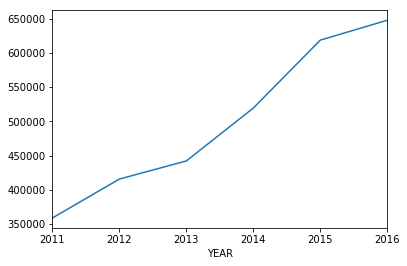

In [123]:
df.groupby("YEAR").size().plot(kind="line")

+ We see that the number of appplications filed each year between 2011 and 2016 keep increasing

#### Break-down of application status per year

In [135]:
df.groupby(["YEAR", "CASE_STATUS"]).size().unstack()

CASE_STATUS,CERTIFIED,CERTIFIED-WITHDRAWN,DENIED,WITHDRAWN
YEAR,,,,
2011,307934,11596,29125,10094
2012,352667,31118,21072,10715
2013,382950,35432,12118,11580
2014,455144,36350,11881,16024
2015,547277,41071,10913,19448
2016,569637,47092,9170,21885
